In [ ]:
from __future__ import print_function, division
from builtins import range

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [ ]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 100

In [ ]:
# load in pre-tained word vectors
print("Loading word vectors...")
word2vec = {}
with open(os.path.join('data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

In [ ]:
# prepare the text smaples and their labels
print('Loading in data...')

attack_data = pd.read_csv('data/attackset.csv')
sentences = attack_data['Web Description'].fillna('DUMMY_VALUE').values
possible_labels = ['Bruteforce', 'DoS', 'insider', 'phishing', 'ransomware', 'Trojan', 'Web']
targets = attack_data[possible_labels].values

In [ ]:
# convert the sentences into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sequences)
print('median sequence length: ', s[len(s) // 2])
print('max word index: ', max(max(seq) for seq in sequences if len(seq) > 0))

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

In [ ]:
# pad sequence so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) +1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=VALIDATION_SPLIT, random_state=101)

In [ ]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [ ]:
print('Building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

In [ ]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
print('Training model...')
r = model.fit(
    X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)

Training model...
Epoch 1/100
5/5 [==============================] - 1s 163ms/step - loss: 0.4377 - accuracy: 0.2500 - val_loss: 0.3033 - val_accuracy: 0.3631
Epoch 2/100
5/5 [==============================] - 1s 103ms/step - loss: 0.3153 - accuracy: 0.3662 - val_loss: 0.2892 - val_accuracy: 0.4076
Epoch 3/100
5/5 [==============================] - 1s 104ms/step - loss: 0.2967 - accuracy: 0.4331 - val_loss: 0.2961 - val_accuracy: 0.3822
Epoch 4/100
5/5 [==============================] - 1s 108ms/step - loss: 0.2781 - accuracy: 0.5653 - val_loss: 0.2526 - val_accuracy: 0.6815
Epoch 5/100
5/5 [==============================] - 1s 105ms/step - loss: 0.2949 - accuracy: 0.4857 - val_loss: 0.2528 - val_accuracy: 0.4968
Epoch 6/100
5/5 [==============================] - 1s 112ms/step - loss: 0.2253 - accuracy: 0.7134 - val_loss: 0.2244 - val_accuracy: 0.5287
Epoch 7/100
5/5 [==============================] - 1s 109ms/step - loss: 0.2376 - accuracy: 0.5924 - val_loss: 0.1788 - val_accuracy: 0.

5/5 [==============================] - 1s 153ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 0.8726
Epoch 59/100
5/5 [==============================] - 1s 176ms/step - loss: 0.1321 - accuracy: 0.9124 - val_loss: 0.1042 - val_accuracy: 0.8917
Epoch 60/100
5/5 [==============================] - 1s 151ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1035 - val_accuracy: 0.8790
Epoch 61/100
5/5 [==============================] - 1s 234ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1089 - val_accuracy: 0.8790
Epoch 62/100
5/5 [==============================] - 1s 205ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1140 - val_accuracy: 0.8790
Epoch 63/100
5/5 [==============================] - 1s 138ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.8790
Epoch 64/100
5/5 [==============================] - 1s 134ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1219 - val_accuracy: 0.8790
Epoch 65/100
5/5 [=

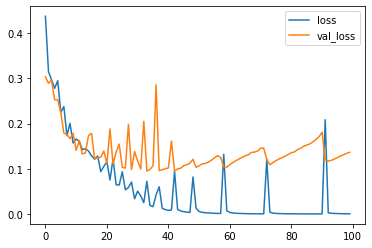

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

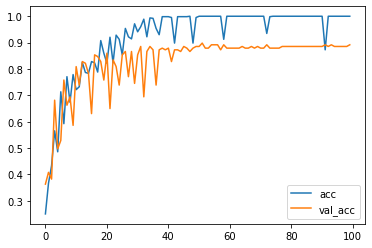

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9939343136893696


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
probability = model.predict(X_test)

In [ ]:
thresh = 0.5
predictions = np.array([[1 if i > thresh else 0 for i in j] for j in probability])

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00        53
           4       1.00      0.76      0.86        41
           5       0.00      0.00      0.00         4
           6       0.79      0.86      0.82        57

   micro avg       0.91      0.85      0.88       157
   macro avg       0.40      0.37      0.38       157
weighted avg       0.89      0.85      0.86       157
 samples avg       0.84      0.85      0.85       157

